In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import helper
style.use('fivethirtyeight')

In [2]:
colors = ["#FF0B04", "#F1BE48",
           "#B9975B", "#8B5B29",
           "#524727",
         ]
sns.set_palette(sns.color_palette(colors))

## Data processing

In [3]:
housing = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0,low_memory = False)


train, test = helper.data_processing_wrapper(housing,
                                               num_to_cat_list = ['MSSubClass'])


In [4]:
cat_feats = train.select_dtypes(['object','bool']).columns.to_list()


In [5]:
num_cols = train.select_dtypes(['float64','int64']).columns.to_list()
num_cols.remove('SalePrice')


## Simple linear model

In [6]:
def simple_linear_model_score(train, test, cols, target):
    ols = linear_model.LinearRegression()
    X = train[cols]
    cat_feats = X.select_dtypes(['object','bool']).columns.to_list()
    transformer = ColumnTransformer([("Cat", OneHotEncoder(handle_unknown = 'ignore'), cat_feats)], remainder='passthrough')
    X = transformer.fit_transform(X)
    y = np.log(train[target])
    
    ols.fit(X, y)
    train_score = ols.score(X, y)
    
    X_tst = test[cols]
    X_tst = transformer.transform(X_tst)
    y_tst = np.log(test[target])
    test_score = ols.score(X_tst, y_tst)
    
    return train_score, test_score

The kitchen sink model of every feature over learns. And has a negative test score

In [7]:
simple_linear_model_score(train, test, cat_feats+num_cols, 'SalePrice')

(0.9577939177156539, 0.9049441938900812)

The numerical kitchen sink model is very successful

In [8]:
simple_linear_model_score(train, test, num_cols, 'SalePrice')

(0.9290445015300175, 0.8849212267144517)

The numerical kitchen sink model gets better when we selectively pick our favorite categorical features

In [9]:
fav_cat = ['YearBuilt', 'ExterQual', 'Neighborhood', 'KitchenQual']
simple_linear_model_score(train, test, num_cols+fav_cat, 'SalePrice')

(0.9418792481441322, 0.8992313787558742)

We can see that as we add more and more numerical features our model gets better.

In [10]:
k=100
cols = train.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cols = cols[1:]
for num_features in range(1,len(cols)):
    print(cols[num_features])
    print(simple_linear_model_score(train, test, cols[1:1+num_features], 'SalePrice'))

GrLivArea
(0.5361242929283243, 0.5052486795731859)
ExterQual
(0.7034962809602388, 0.6644905975921633)
TotalBsmtSF
(0.7792598241555013, 0.7229657933399387)
KitchenQual
(0.7974247390402703, 0.7489550650148744)
1stFlrSF
(0.7975069805128663, 0.7497354661616471)
GarageArea
(0.8182544807598195, 0.779205489561503)
GarageCars
(0.8229613212881246, 0.7862240548493213)
BsmtQual
(0.8367316241545875, 0.8093688234853456)
YearBuilt
(0.8496799637760847, 0.8201252110298075)
FullBath
(0.8515427358211811, 0.8194532379214836)
GarageFinish
(0.8546721816101726, 0.8239315804336104)
FireplaceQu
(0.862791589110423, 0.8355690508933211)
MasVnrArea
(0.863014924192381, 0.8357178472479138)
TotRmsAbvGrd
(0.8634271653730479, 0.8341419606401707)
YearRemodAdd
(0.8695869148482882, 0.8386413512424243)
Fireplaces
(0.8735302259811796, 0.8403365999459429)
BsmtFinSF1
(0.8805143918287985, 0.8482424745087166)
HeatingQC
(0.8819825209355477, 0.8512038129217325)
BsmtExposure
(0.8837381955399547, 0.8524812209245907)
LotFrontage
(0

## Lasso

lasso with all columns 

In [11]:
def lasso_linear_model_score(train_, test_, alpha, target, 
                             categorical_features,
                             drop_cols = ['SalePrice', 'TotalBsmtSF']):
    scaler = StandardScaler(with_mean=False)
    ols = linear_model.LinearRegression()
    
    
    X = train_.drop(drop_cols,axis=1)
    transformer = ColumnTransformer([("Cat", 
                                      OneHotEncoder(handle_unknown = 'ignore'), 
                                      categorical_features)], remainder='passthrough')
    X = transformer.fit_transform(X)
    X = scaler.fit_transform(X)
    y = np.log(train_[target])
    lasso = linear_model.Lasso(alpha=alpha)
    selector = SelectFromModel(estimator=lasso)
    X = selector.fit_transform(X, y)
    
    ols.fit(X,y)
    train_score = ols.score(X,y)

    X_tst = test_.drop(drop_cols,axis=1)
    X_tst = transformer.transform(X_tst)
    X_tst = scaler.transform(X_tst)
    y_tst = np.log(test_[target])
    X_tst = selector.transform(X_tst)
    test_score = ols.score(X_tst,y_tst)
    
    
    feat_names = transformer.get_feature_names()
    mask = selector.get_support()
    lasso_feats = [a for a, b in zip(feat_names, mask) if b]
    
    return train_score, test_score,lasso_feats

##########

lasso_linear_model_score(train, test, 0.1, 'SalePrice', 
                             cat_feats,
                             drop_cols = ['SalePrice', 'TotalBsmtSF'])




(0.874653311752264,
 0.8379021385124785,
 ['GrLivArea',
  'OverallQual',
  'YearBuilt',
  'BsmtQual',
  '1stFlrSF',
  'KitchenQual',
  'GarageCars',
  'GarageArea'])

In [12]:
lasso_linear_model_score(train, test, 0.1, 'SalePrice', 
                             cat_feats,
                             drop_cols = ['SalePrice', 'TotalBsmtSF'])

(0.874653311752264,
 0.8379021385124785,
 ['GrLivArea',
  'OverallQual',
  'YearBuilt',
  'BsmtQual',
  '1stFlrSF',
  'KitchenQual',
  'GarageCars',
  'GarageArea'])

In [13]:
lasso_linear_model_score(train, test, 0.01, 'SalePrice', 
                             cat_feats,
                             drop_cols = ['SalePrice', 'TotalBsmtSF'])

(0.9460319639800638,
 0.9083007695396004,
 ['Cat__x0_160',
  'Cat__x0_30',
  'Cat__x1_C (all)',
  'Cat__x1_RM',
  'Cat__x8_ClearCr',
  'Cat__x8_Crawfor',
  'Cat__x8_Edwards',
  'Cat__x8_GrnHill',
  'Cat__x8_MeadowV',
  'Cat__x8_Somerst',
  'Cat__x8_StoneBr',
  'Cat__x9_Norm',
  'Cat__x11_1Fam',
  'Cat__x11_Twnhs',
  'Cat__x15_BrkFace',
  'Cat__x15_PreCast',
  'Cat__x18_PConc',
  'Cat__x22_N',
  'Cat__x24_Typ',
  'Cat__x25_Attchd',
  'Cat__x29_Normal',
  'GrLivArea',
  'LotFrontage',
  'LotArea',
  'OverallQual',
  'OverallCond',
  'YearBuilt',
  'YearRemodAdd',
  'MasVnrArea',
  'ExterQual',
  'BsmtQual',
  'BsmtExposure',
  'BsmtFinSF1',
  'BsmtFinSF2',
  'HeatingQC',
  '1stFlrSF',
  'BsmtFullBath',
  'KitchenQual',
  'Fireplaces',
  'FireplaceQu',
  'GarageFinish',
  'GarageCars',
  'GarageArea',
  'PavedDrive',
  'ScreenPorch'])

In [14]:
lasso_linear_model_score(train, test, 0.001, 'SalePrice', 
                             cat_feats,
                             drop_cols = ['SalePrice', 'TotalBsmtSF'])

(0.9561244295278687,
 0.9063054954999941,
 ['Cat__x0_150',
  'Cat__x0_160',
  'Cat__x0_20',
  'Cat__x0_30',
  'Cat__x0_45',
  'Cat__x0_50',
  'Cat__x0_60',
  'Cat__x0_70',
  'Cat__x0_85',
  'Cat__x0_90',
  'Cat__x1_A (agr)',
  'Cat__x1_C (all)',
  'Cat__x1_I (all)',
  'Cat__x1_RH',
  'Cat__x1_RL',
  'Cat__x1_RM',
  'Cat__x2_Grvl',
  'Cat__x3_IR2',
  'Cat__x3_IR3',
  'Cat__x4_Bnk',
  'Cat__x4_HLS',
  'Cat__x4_Low',
  'Cat__x6_Corner',
  'Cat__x6_CulDSac',
  'Cat__x6_FR2',
  'Cat__x6_FR3',
  'Cat__x7_Mod',
  'Cat__x8_BrDale',
  'Cat__x8_BrkSide',
  'Cat__x8_ClearCr',
  'Cat__x8_CollgCr',
  'Cat__x8_Crawfor',
  'Cat__x8_Edwards',
  'Cat__x8_Greens',
  'Cat__x8_GrnHill',
  'Cat__x8_IDOTRR',
  'Cat__x8_Landmrk',
  'Cat__x8_MeadowV',
  'Cat__x8_NAmes',
  'Cat__x8_NWAmes',
  'Cat__x8_NoRidge',
  'Cat__x8_NridgHt',
  'Cat__x8_OldTown',
  'Cat__x8_SWISU',
  'Cat__x8_SawyerW',
  'Cat__x8_Somerst',
  'Cat__x8_StoneBr',
  'Cat__x8_Veenker',
  'Cat__x9_Artery',
  'Cat__x9_Feedr',
  'Cat__x9_Norm',


In [49]:
def lasso_graph(alpha_start, alpha_stop, alpha_num,
               train, 
               test,
               target, 
               cat_feats,
               drop_cols = ['SalePrice', 'TotalBsmtSF']
               ):
    lasso_scores_train = []

    lasso_scores_test  = []

    alphas = np.linspace(alpha_start, alpha_stop, alpha_num)

    for alpha in alphas:
        try:
            train_score, test_score,lasso_feats = lasso_linear_model_score(
                train, 
               test,
               alpha, 
               target, 
               cat_feats,
               drop_cols
            )
            lasso_scores_train.append(train_score)
            lasso_scores_test.append(test_score)
        except ValueError:
            print(f'Alpha of {alpha} fails')
            lasso_scores_train.append(0)
            lasso_scores_test.append(0)

    lasso_scores_train = np.array(lasso_scores_train) 
    lasso_scores_test  = np.array(lasso_scores_test)
    #graph
    plt.plot(alphas, lasso_scores_train, label=r'$train\ R^2$')
    plt.plot(alphas, lasso_scores_test, label=r'$test\ R^2$')
    plt.title(r'Lasso Train-Test $R^2$ Comparison')
    # lasso_underfit = lasso_scores_train < lasso_scores_test
    # last_underfit  = np.max(alphas[lasso_underfit])
    # plt.axvline(last_underfit, linestyle='--', color='g', label='optimal lambda', alpha=0.4)
    plt.legend(loc=1)
    plt.xlabel(r'hyperparameter $\lambda$')
    plt.ylabel(r'$R^2$')
    plt.show()

/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were select

Alpha of 0.3181818181818182 fails
Alpha of 0.32727272727272727 fails
Alpha of 0.33636363636363636 fails
Alpha of 0.34545454545454546 fails
Alpha of 0.3545454545454545 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were select

Alpha of 0.36363636363636365 fails
Alpha of 0.3727272727272727 fails
Alpha of 0.38181818181818183 fails
Alpha of 0.3909090909090909 fails
Alpha of 0.4 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were select

Alpha of 0.40909090909090906 fails
Alpha of 0.4181818181818182 fails
Alpha of 0.42727272727272725 fails
Alpha of 0.4363636363636364 fails
Alpha of 0.44545454545454544 fails
Alpha of 0.4545454545454546 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were select

Alpha of 0.4636363636363636 fails
Alpha of 0.47272727272727266 fails
Alpha of 0.4818181818181818 fails
Alpha of 0.49090909090909085 fails
Alpha of 0.5 fails
Alpha of 0.509090909090909 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were select

Alpha of 0.5181818181818182 fails
Alpha of 0.5272727272727272 fails
Alpha of 0.5363636363636364 fails
Alpha of 0.5454545454545454 fails
Alpha of 0.5545454545454546 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were select

Alpha of 0.5636363636363636 fails
Alpha of 0.5727272727272728 fails
Alpha of 0.5818181818181818 fails
Alpha of 0.5909090909090909 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"


Alpha of 0.6 fails
Alpha of 0.609090909090909 fails
Alpha of 0.6181818181818182 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were select

Alpha of 0.6272727272727272 fails
Alpha of 0.6363636363636364 fails
Alpha of 0.6454545454545454 fails
Alpha of 0.6545454545454545 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were select

Alpha of 0.6636363636363636 fails
Alpha of 0.6727272727272727 fails
Alpha of 0.6818181818181818 fails
Alpha of 0.6909090909090908 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were select

Alpha of 0.7 fails
Alpha of 0.709090909090909 fails
Alpha of 0.7181818181818181 fails
Alpha of 0.7272727272727272 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were select

Alpha of 0.7363636363636363 fails
Alpha of 0.7454545454545454 fails
Alpha of 0.7545454545454545 fails
Alpha of 0.7636363636363636 fails
Alpha of 0.7727272727272727 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were select

Alpha of 0.7818181818181817 fails
Alpha of 0.7909090909090909 fails
Alpha of 0.7999999999999999 fails
Alpha of 0.8090909090909091 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were select

Alpha of 0.8181818181818181 fails
Alpha of 0.8272727272727273 fails
Alpha of 0.8363636363636363 fails
Alpha of 0.8454545454545453 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"


Alpha of 0.8545454545454545 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"


Alpha of 0.8636363636363635 fails
Alpha of 0.8727272727272727 fails
Alpha of 0.8818181818181817 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were select

Alpha of 0.8909090909090909 fails
Alpha of 0.8999999999999999 fails
Alpha of 0.9090909090909091 fails
Alpha of 0.9181818181818181 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were select

Alpha of 0.9272727272727272 fails
Alpha of 0.9363636363636363 fails
Alpha of 0.9454545454545454 fails
Alpha of 0.9545454545454545 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"
/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were select

Alpha of 0.9636363636363636 fails
Alpha of 0.9727272727272727 fails
Alpha of 0.9818181818181817 fails
Alpha of 0.9909090909090909 fails


/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_base.py:90: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warn("No features were selected: either the data is"


Alpha of 1.0 fails


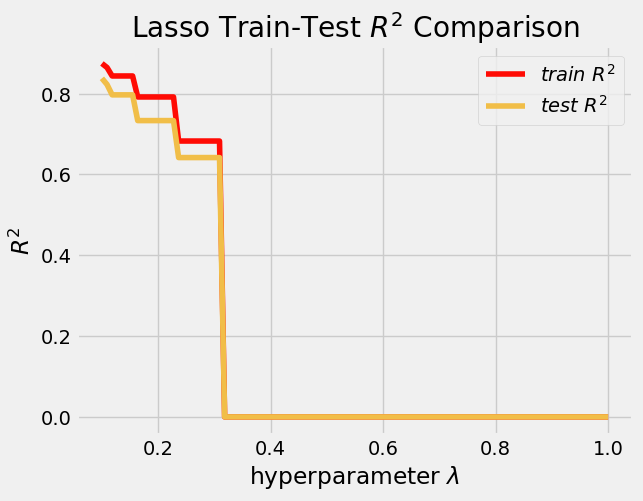

In [39]:
lasso_graph(0.1, 1, 100)

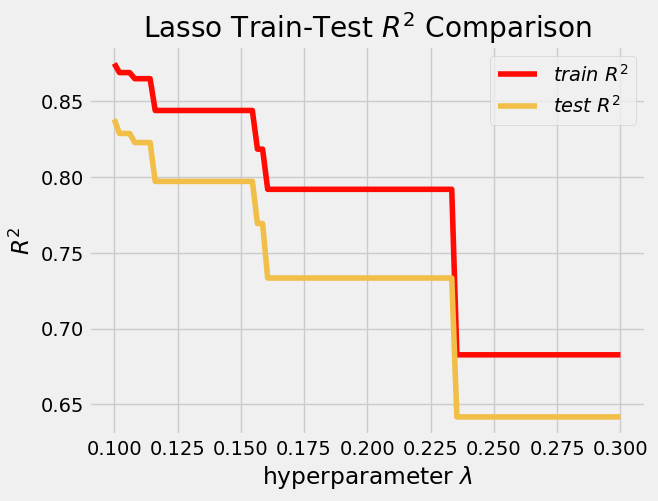

In [40]:
lasso_graph(0.1, 0.3, 100)

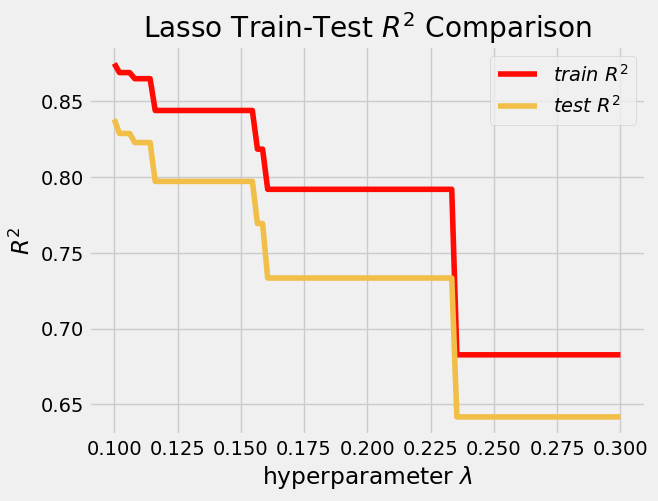

In [50]:
lasso_graph(0.1, 0.3, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

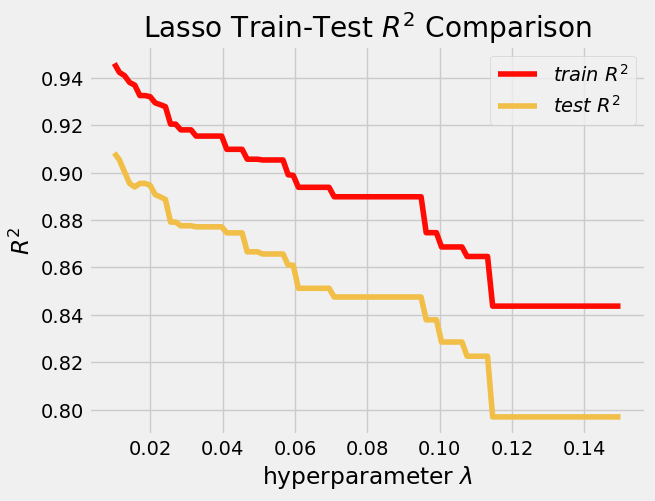

In [43]:
lasso_graph(0.01, 0.15, 100,
            train, 
           test,
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

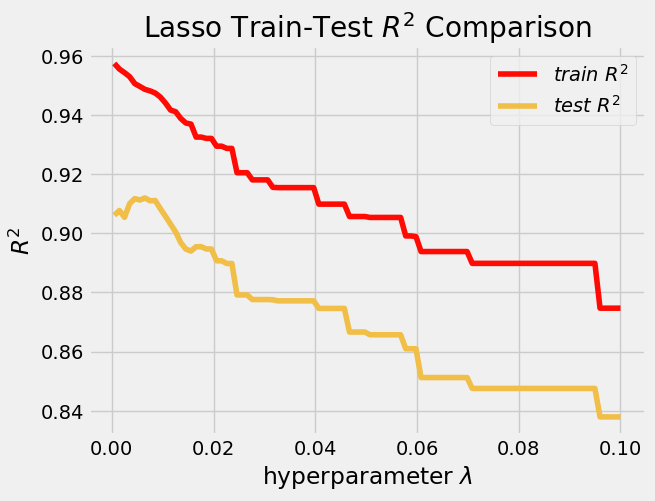

In [47]:
lasso_graph(0.0005, 0.1, 100,
            train, 
           test,
           alpha, 
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

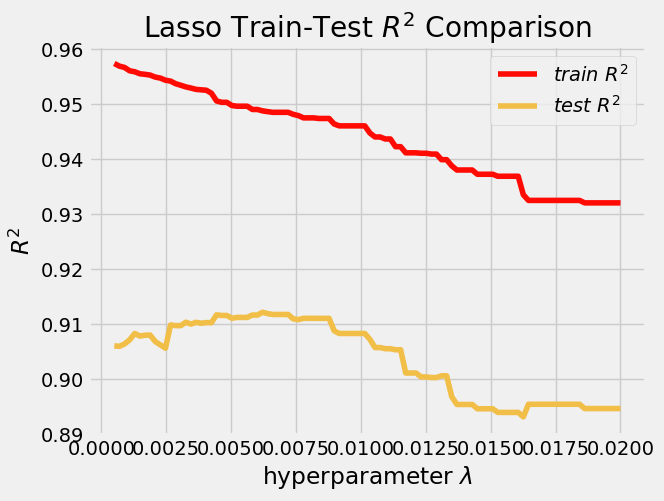

In [48]:
lasso_graph(0.0005, 0.02, 100,
            train, 
           test,
           alpha, 
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

In [54]:
train_score, test_score,feats_005= lasso_linear_model_score(
           train, 
           test,
           0.005, 
           'SalePrice', 
           cat_feats,
           drop_cols = ['SalePrice', 'TotalBsmtSF'])

In [55]:
len(feats_005)

61

In [56]:
test_score

0.9110680246866294

In [57]:
feats_005

['Cat__x0_160',
 'Cat__x0_30',
 'Cat__x1_C (all)',
 'Cat__x1_RH',
 'Cat__x1_RM',
 'Cat__x6_CulDSac',
 'Cat__x8_ClearCr',
 'Cat__x8_Crawfor',
 'Cat__x8_Edwards',
 'Cat__x8_GrnHill',
 'Cat__x8_MeadowV',
 'Cat__x8_NoRidge',
 'Cat__x8_NridgHt',
 'Cat__x8_SawyerW',
 'Cat__x8_Somerst',
 'Cat__x8_StoneBr',
 'Cat__x9_Feedr',
 'Cat__x9_Norm',
 'Cat__x11_1Fam',
 'Cat__x11_Twnhs',
 'Cat__x13_Flat',
 'Cat__x15_BrkFace',
 'Cat__x15_PreCast',
 'Cat__x16_AsbShng',
 'Cat__x18_BrkTil',
 'Cat__x18_PConc',
 'Cat__x20_GLQ',
 'Cat__x22_N',
 'Cat__x24_Maj1',
 'Cat__x24_Maj2',
 'Cat__x24_Typ',
 'Cat__x25_Attchd',
 'Cat__x25_Basment',
 'Cat__x29_Normal',
 'GrLivArea',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'HeatingQC',
 '1stFlrSF',
 'BsmtFullBath',
 'KitchenAbvGr',
 'KitchenQual',
 'Fireplaces',
 'FireplaceQu',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'PavedDrive